In [233]:
!pip install yellowbrick

DEPRECATION: nbclient 0.7.1 has a non-standard dependency specifier jupyter-core!=~5.0,>=4.12. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nbclient or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [234]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [235]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [236]:
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

In [237]:
items = pd.read_csv('data.csv' , encoding='latin1')

Dataset Description: 
1.Invoice No: It represents the no of each transaction. If the number starts from "C" then it is cancelled transaction. Each invioce no can represent multiple items purchased in a single transaction.
2. StockCode: It represents the product code for each item.
3. Description: It provides description of each product.
4. Quantity: Number of units of product in a transcation.
5. Unit Price: It represents the price per product.
5. CustomerID: It represents the unique id assigned to each customer for identifying them.
6. Country: It repesents the country custom come from.


In [238]:
items.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Summary of data sets

In [239]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [240]:
items.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [241]:
items.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


# Data Cleaning

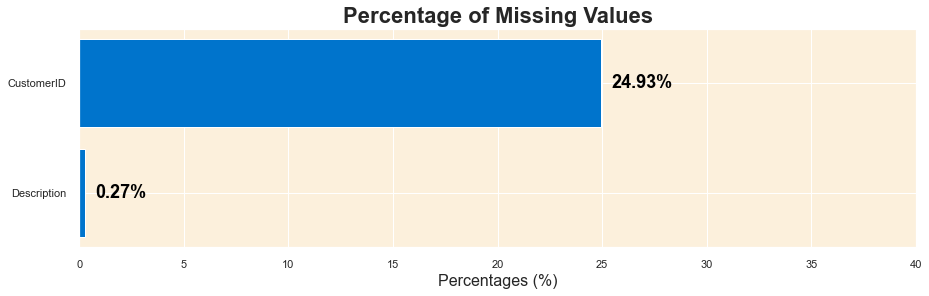

In [242]:
missing_data = items.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / items.shape[0]) * 100

missing_percentage.sort_values(ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#0074cc')

for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

ax.set_xlim([0, 40])

plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [243]:
items[items['CustomerID'].isnull() | items['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [244]:
items = items.dropna(subset=['CustomerID', 'Description'])

In [245]:
items.isnull().sum().sum()

0

# Duplicacy Check

In [246]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = items[items.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom


In [247]:
print(items.duplicated().sum())

items.drop_duplicates(inplace=True)

5225


In [248]:
items.shape[0]

401604

In [249]:
# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
items['Transaction_Status'] = np.where(items['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

cancelled_transactions = items[items['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


In [250]:
cancelled_percentage = (cancelled_transactions.shape[0] / items.shape[0]) * 100

print(cancelled_percentage)

2.209141343213713


In [251]:
unique_stock_codes = items['StockCode'].nunique()

print(unique_stock_codes)

3684


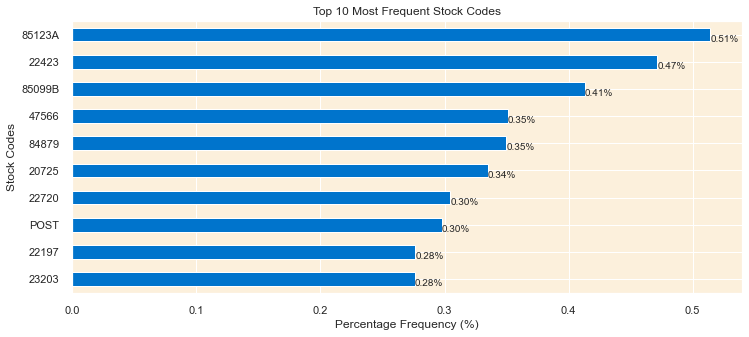

In [252]:
top_10_stock_codes = items['StockCode'].value_counts(normalize=True).head(10) * 100

plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#0074cc')

for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [253]:
unique_stock_codes = items['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
dtype: int64


In [254]:
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [255]:
percentage_anomalous = (items['StockCode'].isin(anomalous_stock_codes).sum() / len(items)) * 100

print(f"Percentage of records with anomalous stock codes is: {percentage_anomalous:.2f}%")

Percentage of records with anomalous stock codes is: 0.48%


In [256]:
items = items[~items['StockCode'].isin(anomalous_stock_codes)]

In [257]:
items.shape[0]

399689

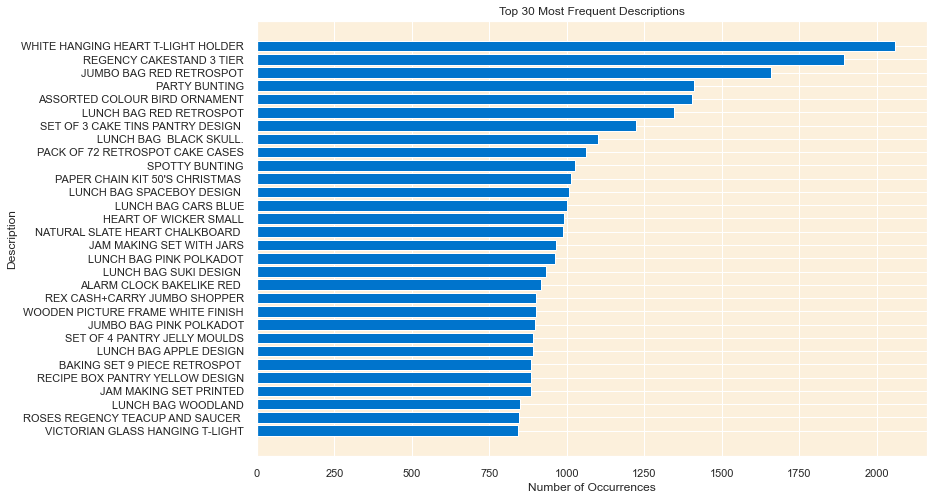

In [258]:
# Calculate the occurrence of each unique description and sort them
description_counts = items['Description'].value_counts()

top_30_descriptions = description_counts[:30]

plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#0074cc')

plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

plt.show()

In [259]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = items['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

print(" unique descriptions containing lowercase characters")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

 unique descriptions containing lowercase characters
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


In [260]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Calculate the percentage of records with service-related descriptions
service_related_percentage = items[items['Description'].isin(service_related_descriptions)].shape[0] / items.shape[0] * 100

# Print the percentage of records with service-related descriptions
print(f"Percentage of records with service-related descriptions is: {service_related_percentage:.2f}%")

# Remove rows with service-related information in the description
items = items[~items['Description'].isin(service_related_descriptions)]

items['Description'] = items['Description'].str.upper()

Percentage of records with service-related descriptions is: 0.02%


In [261]:
items.shape[0]

399606

In [262]:
[items['UnitPrice'].describe()]

[count    399606.000000
 mean          2.904957
 std           4.448796
 min           0.000000
 25%           1.250000
 50%           1.950000
 75%           3.750000
 max         649.500000
 Name: UnitPrice, dtype: float64]

In [263]:
items[items['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


In [264]:
items = items[items['UnitPrice'] > 0]

In [265]:
items.reset_index(drop=True, inplace=True)

In [266]:
items.shape[0]

399573

In [267]:
items['InvoiceDate'] = pd.to_datetime(items['InvoiceDate'])

items['InvoiceDay'] = items['InvoiceDate'].dt.date

customer_data = items.groupby('CustomerID')['InvoiceDay'].max().reset_index()

most_recent_date = items['InvoiceDay'].max()

customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [268]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [269]:
total_transactions = items.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

total_products_purchased = items.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


In [270]:
items['Total_Spend'] = items['UnitPrice'] * items['Quantity']
total_spend = items.groupby('CustomerID')['Total_Spend'].sum().reset_index()

average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


In [271]:
unique_products_purchased = items.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


In [272]:
items['Day_Of_Week'] = items['InvoiceDate'].dt.dayofweek
items['Hour'] = items['InvoiceDate'].dt.hour

days_between_purchases = items.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = items.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

favorite_shopping_hour = items.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


In [273]:
items['Country'].value_counts(normalize=True).head()

United Kingdom    0.890971
Germany           0.022722
France            0.020402
EIRE              0.018440
Spain             0.006162
Name: Country, dtype: float64

In [274]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = items.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [275]:
customer_data['Is_UK'].value_counts()

1    3866
0     416
Name: Is_UK, dtype: int64

In [276]:
# Calculate the total number of transactions made by each customer
total_transactions = items.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = items[items['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


In [277]:
# Extract month and year from InvoiceDate
items['Year'] = items['InvoiceDate'].dt.year
items['Month'] = items['InvoiceDate'].dt.month

monthly_spending = items.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

def calculate_trend(spend_data):
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    else:
        return 0

spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


In [278]:
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

customer_data = customer_data.convert_dtypes()

In [279]:
customer_data.head(10)


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0
5,12352.0,36,8,463,1265.41,158.17625,57,3.13253,1,14,0,1,0.125,316.3525,134.700629,9.351
6,12353.0,204,1,20,89.0,89.0,4,0.0,3,17,0,0,0.0,89.0,0.0,0.0
7,12354.0,232,1,530,1079.4,1079.4,58,0.0,3,13,0,0,0.0,1079.4,0.0,0.0
8,12355.0,214,1,240,459.4,459.4,13,0.0,0,13,0,0,0.0,459.4,0.0,0.0
9,12356.0,22,3,1573,2487.43,829.143333,52,5.315789,1,9,0,0,0.0,829.143333,991.462585,-944.635


In [280]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   string 
 1   Days_Since_Last_Purchase        4282 non-null   Int64  
 2   Total_Transactions              4282 non-null   Int64  
 3   Total_Products_Purchased        4282 non-null   Int64  
 4   Total_Spend                     4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_Products_Purchased       4282 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Day_Of_Week                     4282 non-null   Int64  
 9   Hour                            4282 non-null   Int64  
 10  Is_UK                           4282 non-null   Int64  
 11  Cancellation_Frequency          4282 non-null   Int64  
 12  Cancellation_Rate               42

# Outlier detection

Isolation forest is an algorithm used to find or detect outliers for multidimensional spaces.

In [281]:
model = IsolationForest(contamination=0.05, random_state=0)

customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


Is_Outlier are the outliers that we identified.

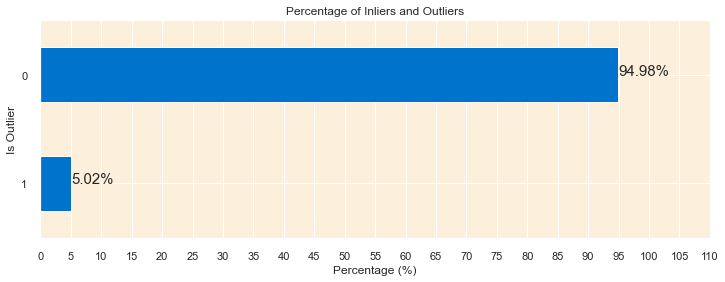

In [282]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#0074cc')

for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [283]:
# Separate the outliers 
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers 
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop  'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

customer_data_cleaned.reset_index(drop=True, inplace=True)

In [284]:
customer_data_cleaned.shape[0]

4067

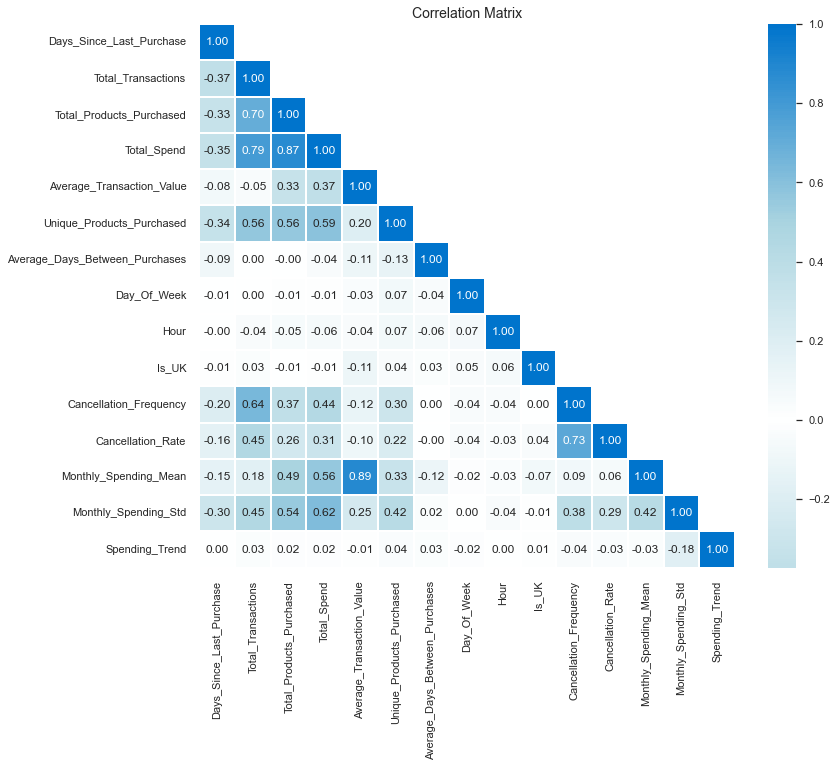

In [285]:
sns.set_style('whitegrid')

corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

colors = ['#0074cc', '#aad4e0', 'white', '#aad4e0', '#0074cc']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)


mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

In [286]:
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

customer_data_scaled = customer_data_cleaned.copy()

customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.345802,-0.477589,-0.754491,-0.813464,-1.317106,-0.908471,-0.310564,1,-1.086929,1,0.420541,0.417623,-1.329018,-0.713318,0.090868
1,12347.0,-0.905575,0.707930,2.005048,2.366920,1.528132,0.815119,-0.128438,1,0.647126,0,-0.545753,-0.432111,0.989511,1.259961,0.116774
2,12348.0,-0.170744,-0.003381,1.863591,0.247087,0.343279,-0.570512,0.672476,3,2.814696,0,-0.545753,-0.432111,0.023997,0.466213,-0.491708
3,12349.0,-0.744516,-0.714692,-0.047205,0.262074,5.418285,0.291283,-0.310564,0,-1.520443,0,-0.545753,-0.432111,4.159521,-0.713318,0.090868
4,12350.0,2.194809,-0.714692,-0.534446,-0.596223,0.043327,-0.655002,-0.310564,2,1.514154,0,-0.545753,-0.432111,-0.220428,-0.713318,0.090868


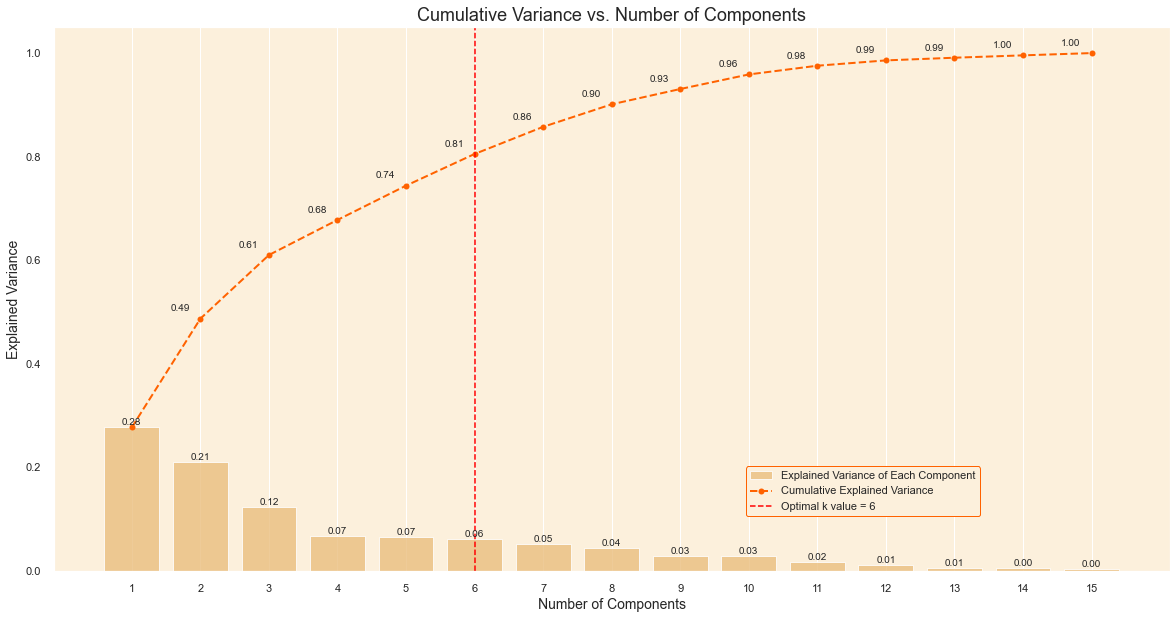

In [287]:
customer_data_scaled.set_index('CustomerID', inplace=True)

pca = PCA().fit(customer_data_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

optimal_k = 6

sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

plt.figure(figsize=(20, 10))

barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [288]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

customer_data_pca = pca.fit_transform(customer_data_scaled)

customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

customer_data_pca.index = customer_data_scaled.index

In [289]:
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.186469,-1.705370,-1.576745,1.008187,-0.411803,-1.658012
12347.0,3.290264,-1.387375,1.923310,-0.930990,-0.010591,0.873150
12348.0,0.584684,0.585019,0.664727,-0.655411,-0.470280,2.306657
12349.0,1.791116,-2.695652,5.850040,0.853418,0.677111,-1.520098
12350.0,-1.997139,-0.542639,0.578781,0.183682,-1.484838,0.062672


In [290]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

pc_items = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_items.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.217859,-0.013986,0.067660,0.273430,-0.240968,-0.373059
Total_Transactions,0.380301,0.014759,-0.259180,-0.138165,-0.017356,-0.028257
Total_Products_Purchased,0.401425,0.007365,0.069133,-0.134806,0.057476,-0.013373
Total_Spend,0.431260,0.010159,0.065165,-0.092047,0.025202,-0.036947
Average_Transaction_Value,0.176225,-0.015544,0.589050,0.114307,0.021847,-0.101738
Unique_Products_Purchased,0.324992,0.063346,0.014010,-0.230502,-0.193981,0.124604
Average_Days_Between_Purchases,-0.022600,-0.036007,-0.127341,-0.160627,0.753462,0.211787
Day_Of_Week,-0.026572,0.994650,-0.006591,0.028870,0.058359,-0.060799
Hour,-0.024259,0.056388,-0.002019,-0.226832,-0.528881,0.621915
Is_UK,-0.001014,0.007435,-0.018378,-0.013419,-0.005353,0.014384


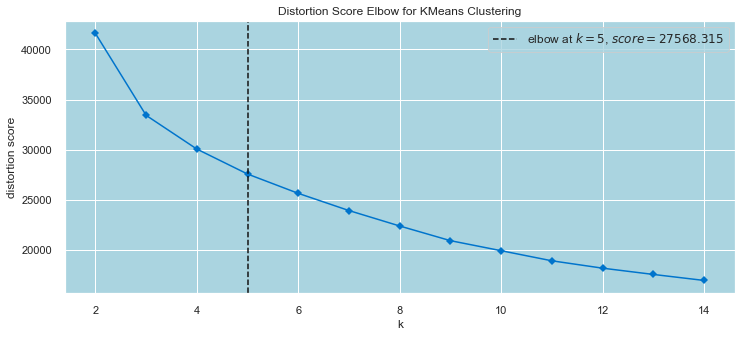

In [291]:
sns.set(style='darkgrid', rc={'axes.facecolor': '#aad4e0'})

sns.set_palette(['#0074cc'])

km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

fig, ax = plt.subplots(figsize=(12, 5))

visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

visualizer.fit(customer_data_pca)

visualizer.show();

In [292]:
def silhouette_analysis(items, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    plt.figure(figsize=figsize)

    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    first_plot = plt.subplot(grid[0, :])

    sns.set_palette(['darkorange'])

    silhouette_scores = []

    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(items)
        labels = km.predict(items)
        score = silhouette_score(items, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(items)

        score = silhouette_score(items, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

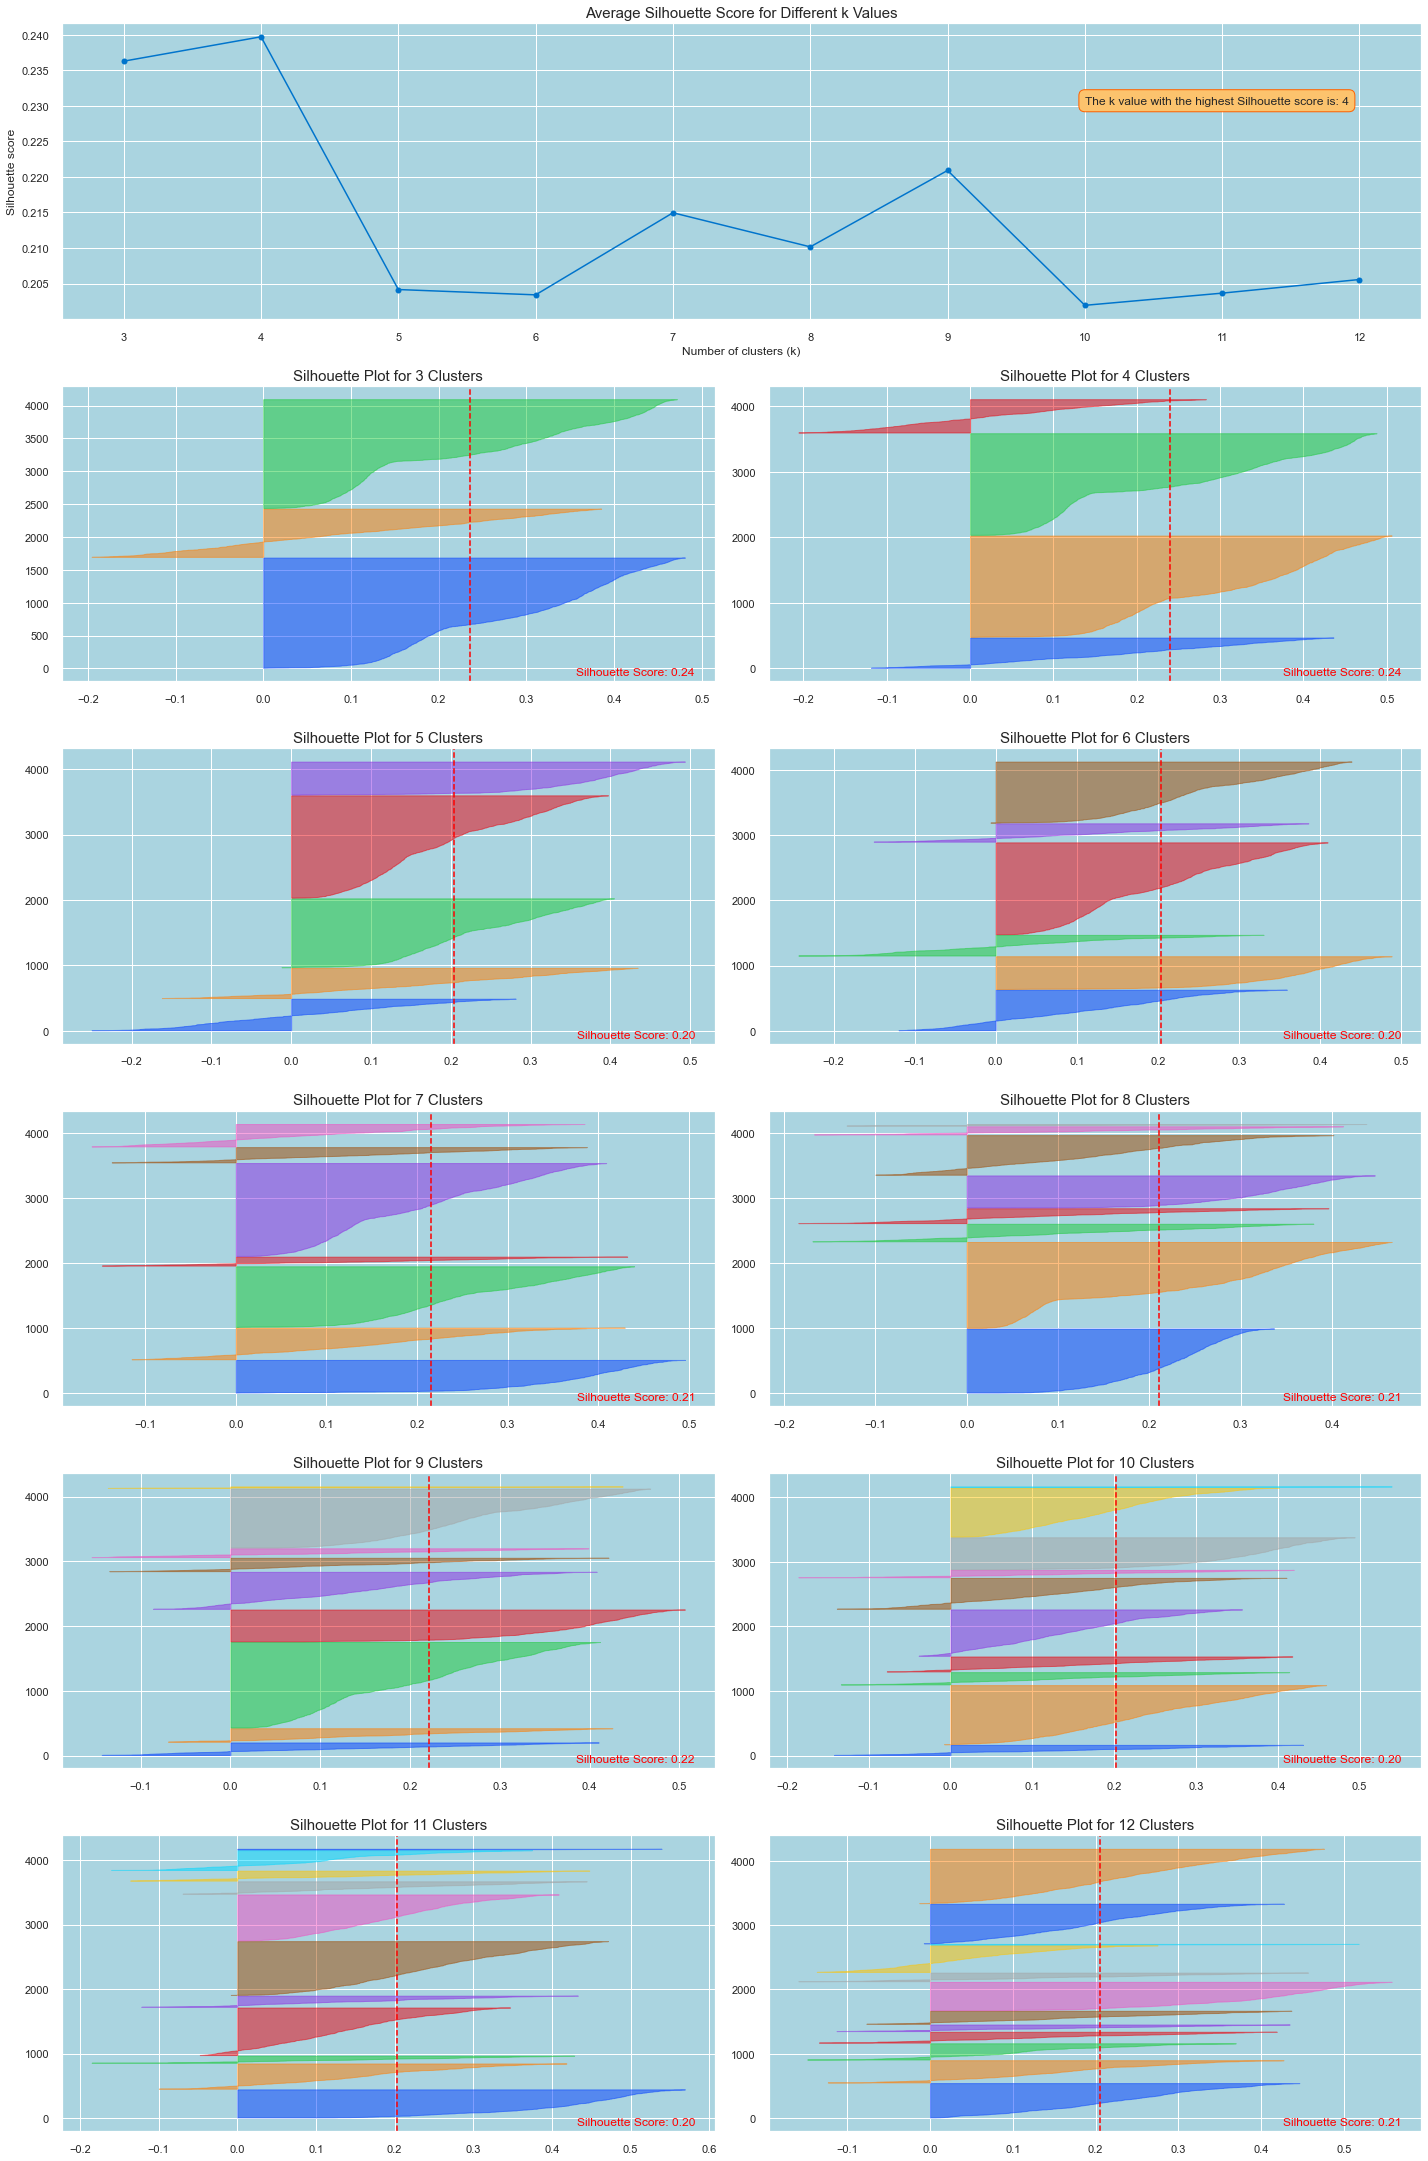

In [293]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))


In [294]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

cluster_frequencies = Counter(kmeans.labels_)

label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

customer_data_cleaned['cluster'] = new_labels

customer_data_pca['cluster'] = new_labels

In [295]:
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,2
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1


In [296]:
colors = ['#e8000b', '#1ac938', '#023eff']

In [297]:
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

fig = go.Figure()

fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#aad4e0", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#aad4e0", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#aad4e0", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

fig.show()

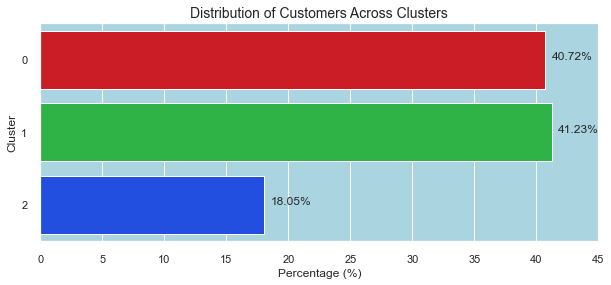

In [298]:
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

plt.show()

In [299]:
num_observations = len(customer_data_pca)

X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4067         |
|    Silhouette Score     | 0.23627137022779887 |
| Calinski Harabasz Score | 1257.1794962921563  |
|  Davies Bouldin Score   | 1.3684055372996031  |
+-------------------------+---------------------+


# Cluster Analysis

# Radar Chart

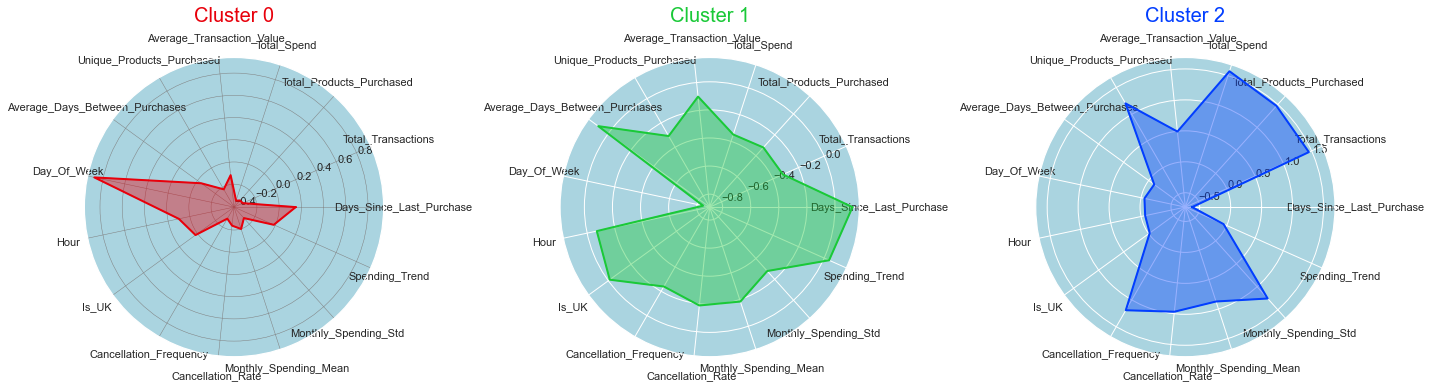

In [300]:
df_customer = customer_data_cleaned.set_index('CustomerID')

scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

cluster_centroids = df_customer_standardized.groupby('cluster').mean()

def create_radar_chart(ax, angles, data, color, cluster):
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1] 
    create_radar_chart(ax[i], angles, data, color, i)

ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

ax[0].grid(color='grey', linewidth=0.5)

plt.tight_layout()
plt.show()

# Histogram Chart

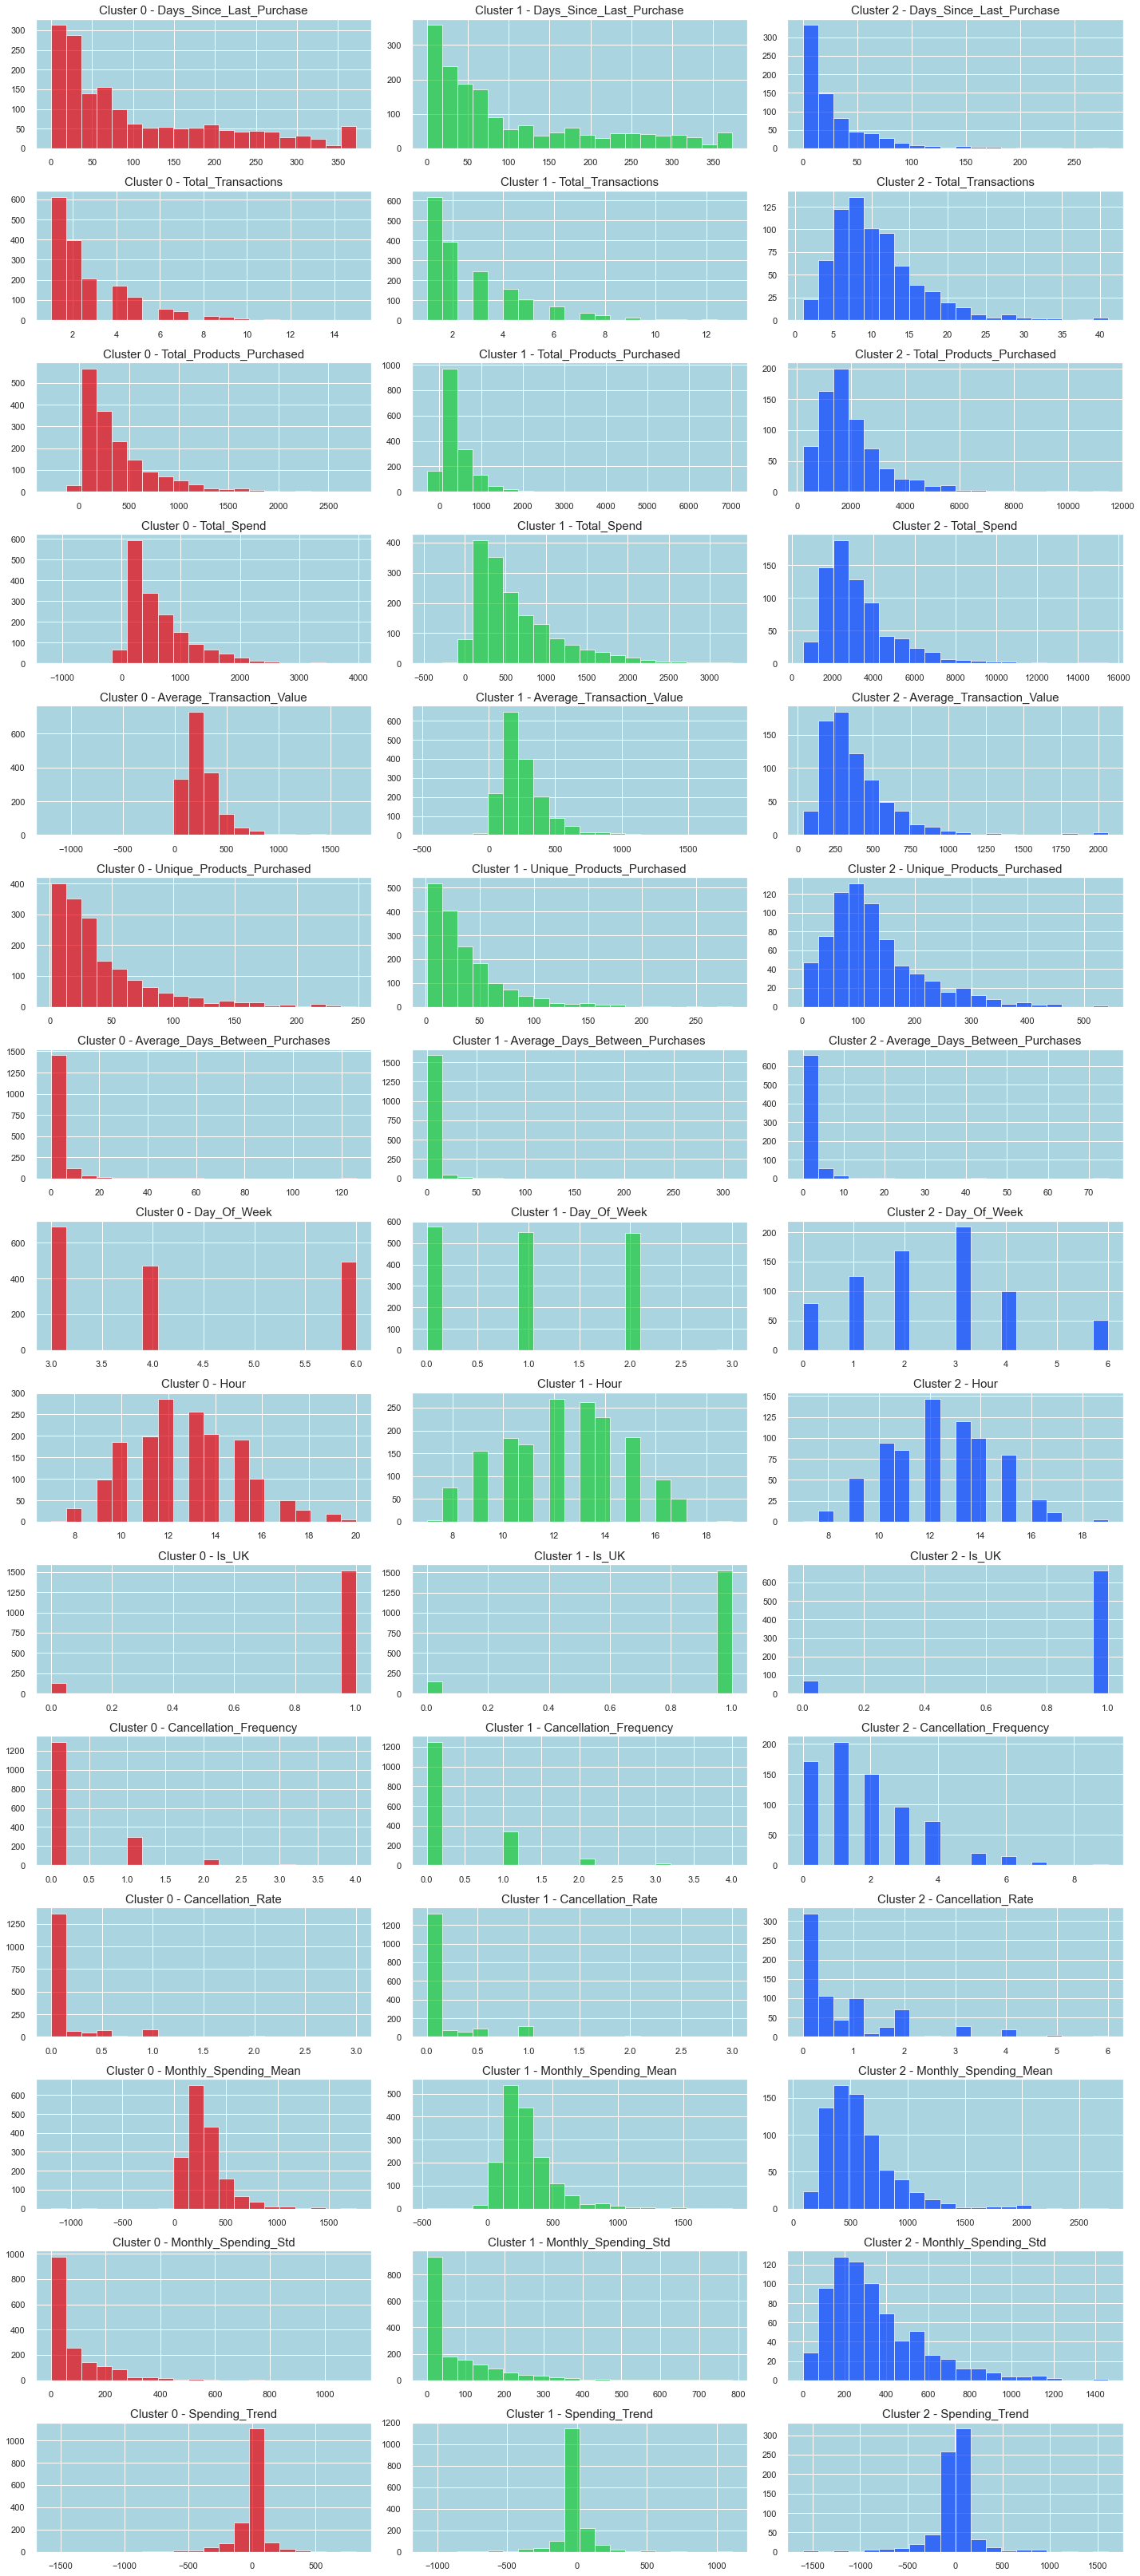

In [301]:
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

plt.tight_layout()
plt.show()

# Recommendation System

In [302]:
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = items[~items['CustomerID'].isin(outlier_customer_ids)]

customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']
    
    for customer in customers_in_cluster:
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
        
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [303]:
print(customer_data_with_recommendations)

      CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0        12348.0                        75                   4   
1        12353.0                       204                   1   
2        12354.0                       232                   1   
3        12361.0                       287                   1   
4        12364.0                         7                   4   
...          ...                       ...                 ...   
4062     18245.0                         7                   8   
4063     18257.0                        39                  11   
4064     18260.0                       172                   8   
4065     18272.0                         2                   7   
4066     18283.0                         3                  16   

      Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                         2332      1437.24                     359.31   
1                           20         89.0                

In [304]:
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:]

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
12348.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
12353.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
12354.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
12361.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
12364.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
...,...,...,...,...,...,...
18245.0,22616,PACK OF 12 LONDON TISSUES,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT
18257.0,22616,PACK OF 12 LONDON TISSUES,84879,ASSORTED COLOUR BIRD ORNAMENT,16014,SMALL CHINESE STYLE SCISSOR
18260.0,22616,PACK OF 12 LONDON TISSUES,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT


In [305]:
def get_recommendations(customer_id, customer_data_cleaned, top_products_per_cluster, customer_purchases):
    cluster = customer_data_cleaned.loc[customer_data_cleaned['CustomerID'] == customer_id, 'cluster'].values[0]

    if cluster not in top_products_per_cluster['cluster'].unique():
        return pd.DataFrame(columns=['StockCode', 'Description'])

    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    
    customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer_id) & 
                                                     (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()

    top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
    top_3_products_not_purchased = top_products_not_purchased.head(3)

    return top_3_products_not_purchased[['StockCode', 'Description']]

customer_id_input = 13101.0  
recommendations_for_customer = get_recommendations(customer_id_input, customer_data_cleaned, top_products_per_cluster, customer_purchases)

print("Recommended Items for Customer ID {}: ".format(customer_id_input))
print(recommendations_for_customer)

Recommended Items for Customer ID 13101.0: 
     StockCode                          Description
3551     18007  ESSENTIAL BALM 3.5G TIN IN ENVELOPE
6437     84879        ASSORTED COLOUR BIRD ORNAMENT
3523     17003                  BROCADE RING PURSE 


In [306]:
customer_recommendation = customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:]

In [307]:
print(customer_recommendation)

           Rec1_StockCode                   Rec1_Description Rec2_StockCode  \
CustomerID                                                                    
12348.0             84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS          84879   
12353.0             84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS          84879   
12354.0             84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS          84879   
12361.0             84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS          84879   
12364.0             84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS          84879   
...                   ...                                ...            ...   
18245.0             22616         PACK OF 12 LONDON TISSUES           84077   
18257.0             22616         PACK OF 12 LONDON TISSUES           84879   
18260.0             22616         PACK OF 12 LONDON TISSUES           84077   
18272.0             22616         PACK OF 12 LONDON TISSUES           84077   
18283.0             84077  WORLD WAR 2 GLIDERS ASSTD

In [308]:
import pickle

In [309]:
pickle.dump(customer_data_with_recommendations, open('customer_recommendations.pkl', 'wb'))